<h1> Quantitative Analysis </h1>

---

<h2> Preprocessing Steps </h2>

<h4>Step 1</h4>

Read data into Pandas dataframe and examine the data.

In [1]:
import numpy as np
import pandas as pd
import json
from pathlib import Path

def load_json_to_df(path: Path) -> pd.DataFrame:
    """
    Takes a file path, opens the .json file at
    that position, and transforms it into a dataframe
    """
    with open(path, 'r') as f:
        json_data = json.load(f)
        return pd.DataFrame({
            "letter": json_data.values()
        }, index = json_data.keys())

DATA_DIR = Path.cwd() / "data"
KAGGLE_FILE_PATH = DATA_DIR / "ww1letters.json"
KAGGLE_METADATA_PATH = DATA_DIR / "index.csv"

kaggle_df = load_json_to_df(KAGGLE_FILE_PATH)
with open(KAGGLE_METADATA_PATH, 'r') as f:
    metadata_df = pd.read_csv(f)
    metadata_df.index = metadata_df["letter_key"]

kaggle_df = kaggle_df.join(
    metadata_df[["year", "language"]],
)
kaggle_df = kaggle_df[kaggle_df["year"].notna()].astype({"year": "int64"})
kaggle_df["language"] = kaggle_df["language"].fillna("english")

print(kaggle_df.head(), "\n")
print(kaggle_df.info())

                                                   letter  year language
arc71   Mercredi 29 septembre 1915\nMa chère Louisette...  1915   french
hl_02   Correspondance militaire adressée à monsieur J...  1914   french
hl_03a  Chère femme, mes deux gosses ainsi que toute m...  1914   french
hl_03b  Chers Mère et frère,\n\nTout ce que je vous re...  1914   french
hl_04   Aux armées le 27 mai 1916\n\n \nChers parents,...  1916   french 

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, arc71 to na_uk_40
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   letter    55 non-null     object
 1   year      55 non-null     int64 
 2   language  55 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.7+ KB
None


In [2]:
DEAREST_PATH = DATA_DIR / "400_letters.json"

dearest_df = load_json_to_df(DEAREST_PATH)

london_years = [1915] * 3 + [1916] * 6
france_years = [1917] * 77
missing_years = [1917] * 13
pow_years = [1918] * 174 + [1917] * 79
sheerness_years = [1919] * 15

dearest_df["year"] = london_years + france_years + missing_years + pow_years + sheerness_years
print(dearest_df.head(), "\n")
print(dearest_df.info())

                                                  letter  year
lo001  Dear Ginger, I have just returned from a holid...  1915
lo002  Zeppelins over London 4th Nov 1915 David to Gi...  1915
lo003  David Joins Army 28 Dec 1915 David to Ginger D...  1915
lo004  How Britain Prepared Ginger (Ethel)  to David ...  1916
lo005  1916 OTC Gidea Park David to Ginger (sister Et...  1916 

<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, lo001 to sh015
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  367 non-null    object
 1   year    367 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB
None


<h4>Step 2</h4>

Retrieve English letters from the Kaggle database and preprocess both datasets.

To do so, we choose to apply tokenisation, lemmatisation, stopword removal, and removal of overly frequent words in order to aid with topic modelling and sentiment analysis.

In [3]:
import nltk
from nltk.corpus import wordnet, stopwords
from collections import Counter

STEMMER = nltk.stem.WordNetLemmatizer()
un_to_wn_map = {"VERB" : wordnet.VERB,
                "NOUN" : wordnet.NOUN,
                "ADJ" : wordnet.ADJ,
                "ADV" : wordnet.ADV}

PUNCTUATIONS = {',', '.', ';', '?', '!', '&', '(', ')', '*', '-', '–', '‘', '’', '“', '”', '[', ']', '…', '+'}
STOP = set(stopwords.words("english")).union(PUNCTUATIONS)

english_kaggle = kaggle_df["letter"][kaggle_df["language"] == "english"]
# print(english_kaggle)

def preprocess(df: pd.DataFrame, common_removed = 0.0) -> (list[str], Counter):
    """
    Takes a series of letters and preprocesses them
    by applying tokenisation, pos-tagging & lemmatisation.
    
    Removes the top <common_removed>% of most frequent
    words from the preprocessed results.
    
    Returns the preprocessed letters and a counter of
    word frequencies.
    """
    letters_preprocessed = []
    word_freqs = Counter()
    
    for letter in df:
        letter_tokens = nltk.tokenize.word_tokenize(letter.lower())
        letter_tagged = nltk.pos_tag(letter_tokens, tagset = "universal")
        letter_lemmas = []
        
        for (token, pos) in letter_tagged:
            token = token.strip('…')
            if token not in STOP:
                if pos in un_to_wn_map.keys():
                    lemma = STEMMER.lemmatize(token, pos = un_to_wn_map[pos])
                else:
                    lemma = STEMMER.lemmatize(token)
                
                letter_lemmas.append(lemma)
                word_freqs[lemma] += 1
        
        letters_preprocessed.append(' '.join(letter_lemmas))

    num_remove = int(common_removed * len(word_freqs))
    words_remove = set([
        item[0] for item in word_freqs.most_common(num_remove)
    ])

    # remove top words
    letters_preprocessed = [
        ' '.join([word for word in letter.split(' ')
                  if word not in words_remove])
        for letter in letters_preprocessed
    ]

    return letters_preprocessed, word_freqs.most_common(num_remove)

REMOVE = 0.02
english_kaggle_pp, english_removed = preprocess(english_kaggle, REMOVE)
dearest_pp, dearest_removed = preprocess(dearest_df["letter"], REMOVE)

In [3]:
import matplotlib.pyplot as plt

def show_freq(freq: Counter, title: str, print_freq = False):
    """ Create a word frequency bar chart """
    ax = plt.subplots()[1]
    ax.bar([item[0] for item in freq],
           [item[1] for item in freq])
    ax.set_title(title)
    plt.xticks(rotation = 60, ha = "right",
               fontsize = 6 )
    plt.show()

    if print_freq:
        print([item[0] for item in freq])

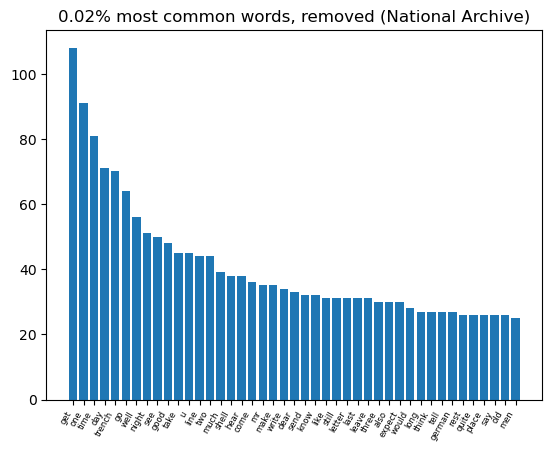

['get', 'one', 'time', 'day', 'trench', 'go', 'well', 'night', 'see', 'good', 'take', 'u', 'line', 'two', 'much', 'shell', 'hear', 'come', 'mr', 'make', 'write', 'dear', 'send', 'know', 'like', 'still', 'letter', 'last', 'leave', 'three', 'also', 'expect', 'would', 'long', 'think', 'tell', 'german', 'rest', 'quite', 'place', 'say', 'old', 'men']


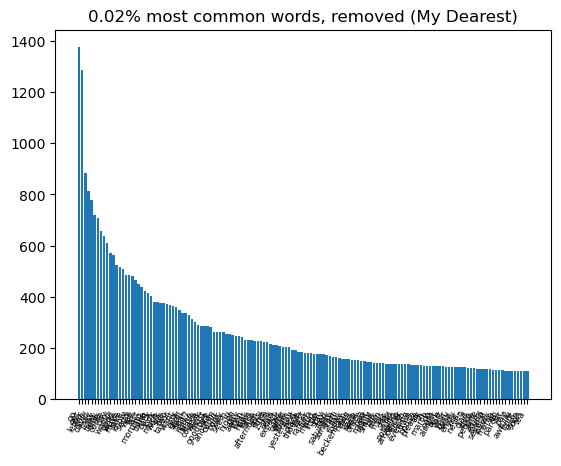

['go', 'get', 'letter', 'one', 'david', 'may', 'say', 'think', 'time', 'come', 'day', 'would', 'good', 'write', 'make', 'take', 'know', 'send', 'well', 'tell', 'last', 'morning', 'like', 'thing', 'back', 'look', 'much', 'work', 'see', 'two', 'taylor', 'want', 'mr', 'give', 'shall', 'dear', '1917', 'home', 'leave', 'course', 'week', 'must', 'goodbye', 'ask', 'another', 'could', 'book', 'way', 'seem', 'u', 'night', 'girl', 'away', 'men', 'hear', 'hope', 'long', 'also', 'afternoon', 'mrs', 'find', '1918', 'still', 'read', 'expect', 'put', 'quite', 'ethel', 'room', 'yesterday', 'next', 'place', 'though', 'first', 'rather', 'turn', 'maud', 'little', 'yet', 'stay', 'bed', 'saturday', 'sunday', 'start', 'call', 'today', 'beckenham', 'news', 'feel', 'keep', 'walk', 'office', 'bad', 'might', 'really', 'small', 'talk', 'man', 'miss', 'etc', 'stop', 'old', 'nothing', 'anything', 'officer', 'finish', 'evening', 'train', 'house', 'please', 'try', 'th', 'march', 'do', 'post', 'alright', 'nice', 'sor

In [5]:
show_freq(english_removed, f"{REMOVE}% most common words, removed (National Archive)", True)
show_freq(dearest_removed, f"{REMOVE}% most common words, removed (My Dearest)", True)

<h4>COMMENTS</h4>

As expected, we remove a lot more words from the My Dearest dataset simply because it is much larger, and thus contains far more tokens. Both sets of removed words follow Zipf's law, even with common stopwords (as considered by the NLTK set of stopwords) already being omitted during preprocessing.

Many of these words are "basic" function or minimal content words, such as "may", "would", "go", and so on. Words commonly found as per letterwriting conventions are also included here, such as "dear", "write", "goodbye", as well as the years and the names of the correspondents. Additionally, household words relating to war are also in this category, such as the word "war" itself, "trench", "german", and "office".

Removing the top 0.02% seems to strike an adequate balance between retaining as much useful information as possible while also getting rid of redundant or meaningless data, in order to better train our classification models. It is already clear that potentially crucial information is lost: opinion words like "lovely" and "awfully" are already removed, hindering sentiment analysis, and topic-related words like proper names and time phrases are also out of the question.

<h4>Step 3</h4>

Replace the letters in the database with their preprocessed version.

In [6]:
english_data_df = kaggle_df[kaggle_df["language"] == "english"].copy()
english_data_df = english_data_df.drop(columns = ["language"])
english_data_df["letter"] = english_kaggle_pp

dearest_df["letter"] = dearest_pp

data_df = pd.concat([dearest_df, english_data_df], ignore_index = False)
data_df.index.name = "keys"

print(data_df.head(), "\n")
print(data_df.info())

data_df.to_csv(DATA_DIR / "preprocessed_letters.csv")

                                                  letter  year
keys                                                          
lo001  ginger return holiday brighton glorious chesha...  1915
lo002  zeppelin london 4th nov 1915 ginger 56 ramsden...  1915
lo003  join army 28 dec 1915 ginger dec 28th 1915 ram...  1915
lo004  britain prepared ginger somewhere u.s.a. somet...  1916
lo005  1916 otc gidea park ginger sister live usa cad...  1916 

<class 'pandas.core.frame.DataFrame'>
Index: 403 entries, lo001 to na_uk_40
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  403 non-null    object
 1   year    403 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.4+ KB
None


---

<h2>General Statistics</h2>

Let's see if we can learn anything interesting about the data just through numerical analysis - no machine learning or language models required!

We will calculate:
- text and vocab sizes
- type-token ratios
- unigram and bigram frequencies (total and by individual year)

A key concern to keep in mind while computing these general statistics is that our dataset is hugely biased towards the correspondences of just one specific family, whose letters comprises the vast majority of our data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk import bigrams
from collections import Counter
from pathlib import Path

DATA_DIR = Path.cwd() / "data"
REMOVE = 0.02
data_df = pd.read_csv(DATA_DIR / "preprocessed_letters.csv")
letters = data_df["letter"]

DATA_SIZE = len(letters)
size_measures = {
    "text size": [],
    "vocab size": [],
    "type-token ratio": []
}
total_freq = Counter()
bigram_freq = Counter()
    
for letter in letters:
    tokens = letter.split(' ')
    text_size = len(tokens)
    vocab_size = len(set(tokens))
    
    size_measures["text size"].append(text_size)
    size_measures["vocab size"].append(vocab_size)
    size_measures["type-token ratio"].append(round(vocab_size / text_size, 2))
    
    total_freq += Counter(tokens)

    for pair in bigrams(tokens):
        bigram_freq[f"{pair[0]} {pair[1]}"] += 1

Number of letters:  403 

---

Average text size is 132.06

Highest text size is 430
CORRESPONDING LETTER:
>> zeppelin london 4th nov 1915 ginger 56 ramsden rd balham nov 4th 1915 ginger zeppelin fortunate enough view whole great many happen 9.30. earlier passing zep raid tonight notice report paper somewhere happen common heard boom boom boom gun test something often practice ground bomb throw clapham common almost immediately boom strike zep sky saw burst firing saw beauty behind tree beautiful sight large cigar shape bar silver float along shin light search light fine clear star shin moon pretty dark throw zep gun worth shell burst world star pop hit stood watch sight south east later 12 clock thoroughly amongst suppose return view aldgate large elongated star shell flash light shell near definitely remain minute appear search light hover around outside nearly others comparatively damage although loss life great drop bomb new within 100 yard chancery lane gray inn harry thick tale e

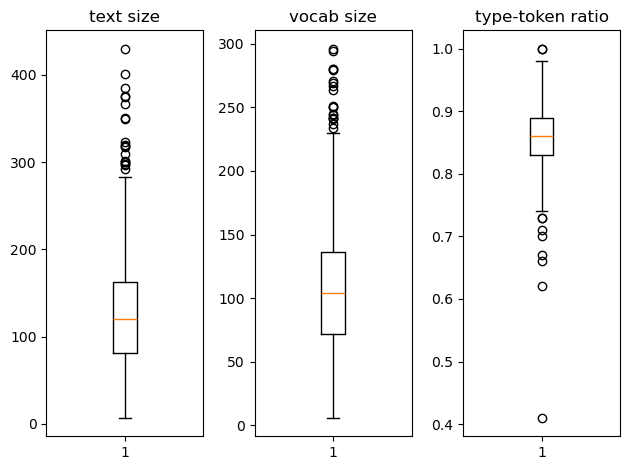

In [2]:
print("Number of letters: ", DATA_SIZE, "\n\n---")

fig, axes = plt.subplots(1, 3)

# i could make a box plot???
count = 0
for measure, vals in size_measures.items():
    axes[count].boxplot(vals)
    axes[count].title.set_text(measure)
    count += 1
    
    print(f"\nAverage {measure} is {round(sum(vals) / DATA_SIZE, 2)}")
    print(f"\nHighest {measure} is {max(vals)}")
    print("CORRESPONDING LETTER:\n>>", letters[vals.index(max(vals))])
    print(f"\nLowest {measure} is {min(vals)}")
    print("CORRESPONDING LETTER:\n>>", letters[vals.index(min(vals))])
    print("\n---")

fig.tight_layout()
plt.show()

<h4>OBSERVATIONS</h4>

We see that the average text length of 132 words is just slightly higher than the average vocabulary size, which is 111 words. This is, of course, after removing stopwords and frequently occurring words - otherwise, both counts would likely be much higher. The distributions of both text and vocabulary sizes are mostly normally distributed with a slight positive skew, with letters of lengths over 300 or vocabularies greater than 225 being outliers. As the example of the shortest letter indicates, many letters have likely been censored or unreceived.

The same fact also means that the type-token ratio, which after preprocessing is around 0.86, would also probably have been much lower if we did not remove those words. Despite this, the high type-token ratio still indicates a varied vocabulary across all of the letters written, possibly correlating with a high amount of different topics contained within a single letter. 

Number of unique tokens: 7737

30 most common words (after removing top 0.02%)
since:           129
receive:         125
month:           121
lot:             119
new:             119
many:            118
hour:            117
order:           117
present:         116
suppose:         115
use:             112
something:       111
sleep:           111
holiday:         110
usual:           110
however:         109
ever:            109
always:          109
whole:           108
road:            108
paper:           107
july:            107
balham:          106
thank:           105
bit:             104
till:            104
fire:            103
weather:         103
part:            101
fact:            101

30 least common words
b.e.f.:          1
j.:              1
lance:           1
3343:            1
non-fighting:    1
a.p.c:           1
ernie:           1
redford:         1
girl:            1
cowan:           1
morris:          1
f.r:             1
agreement:       1
them…kind:       1
th

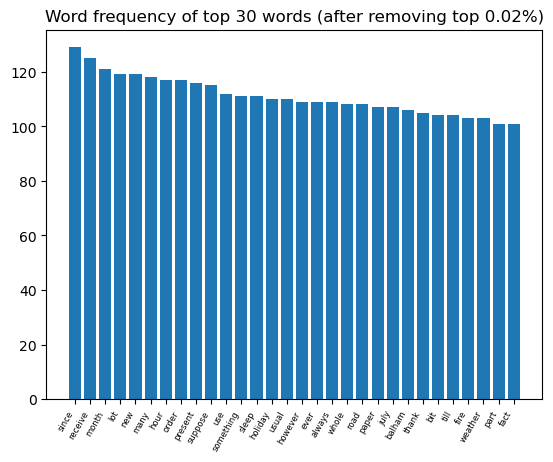

In [4]:
print("Number of unique tokens:", len(total_freq))

NUM_COMMON = 30
top_common = total_freq.most_common(NUM_COMMON)

print(f"\n{NUM_COMMON} most common words (after removing top {REMOVE}%)")
for word, freq in top_common:
    print(f"{word}:{' ' * (16 - len(word))}{freq}")

print(f"\n{NUM_COMMON} least common words")
for word, freq in list(reversed(total_freq.most_common()))[:NUM_COMMON]:
    print(f"{word}:{' ' * (16 - len(word))}{freq}")

show_freq(top_common, f"Word frequency of top {NUM_COMMON} words (after removing top {REMOVE}%)")

<h4>OBSERVATIONS</h4>

Not too much information can be gathered from this. We again see the usual words that relate to either war, daily routines, or letterwriting, as well as many function words like "since" and "many". This time, the words are not distributed according to Zipf's law, which makes sense after we've removed all the most common words which show the most drastic differences in frequency.

The least common words mostly contain initials or proper names related to ongoing battles. These are likely time-specific references, such as the "Somme", and can be hard to get a general picture of but could prove very helpful in providing a timeline of the war.

Number of unique bigrams: 47553

30 most common bigrams
red cross:               29
1 lb:                    29
18 manor:                27
general manager:         25
manor road:              24
pair sock:               17
spend weekend:           17
sit fire:                17
lb tin:                  17
board education:         15
1 st:                    14
½ lb:                    14
matter fact:             14
ginger linn:             14
1919 darling:            14
love love:               13
love mamma:              13
thank goodness:          13
thank indeed:            13
whole lot:               12
many thanks:             12
forget mention:          12
new leaf:                12
kind regard:             12
point view:              11
fanny usa:               11
ever since:              11
poor soul:               10
great part:              10
weather glorious:        10

30 least common bigrams
news kind:               1
let news:                1
drop let:                

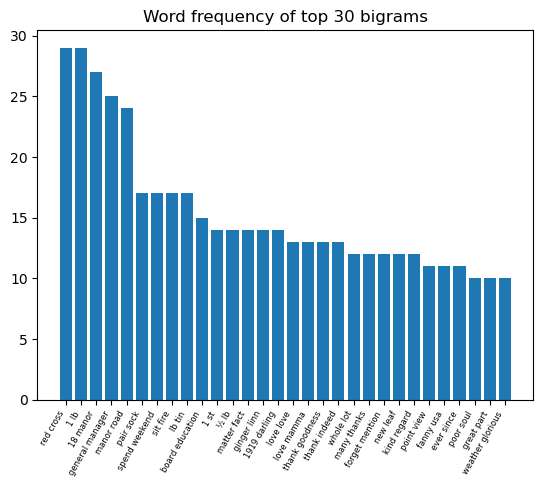

In [5]:
print("Number of unique bigrams:", len(bigram_freq))

top_bigrams = bigram_freq.most_common(NUM_COMMON)

print(f"\n{NUM_COMMON} most common bigrams")
for pair, freq in top_bigrams:
    print(f"{pair}:{' ' * (24 - len(pair))}{freq}")

print(f"\n{NUM_COMMON} least common bigrams")
for pair, freq in list(reversed(bigram_freq.most_common()))[:NUM_COMMON]:
    print(f"{pair}:{' ' * (24 - len(pair))}{freq}")

show_freq(top_bigrams, f"Word frequency of top {NUM_COMMON} bigrams")

<h4>OBSERVATIONS</h4>

The bigrams do provide us with more insight about the soldiers' writing styles and concerns. Among the top of these are healthcare ("red cross"), food and ration ("1 lb"), and gratitude and love towards family.

As with the least frequent words, the least common bigrams are also battle-related and time-specific, mentioning battle plans ("might drop"), army movement ("transfer regiment"), and army divisions and officers. It is interesting that, although soldiers do talk about war in general terms, they often do not use war-specific jargon in their letters. There are many possible reasons for this avoidance:

- censorship (to avoid leaking confidential plans)
- sentiment (to prevent family from worrying)
- disinterest (many soldiers got tired of the war towards the end)
- redundance (families may already have read about the war in the news, so dwelling on it can be a waste of ink)

---
Number of letters in 1914:  1

Most common tokens of letters in 1914


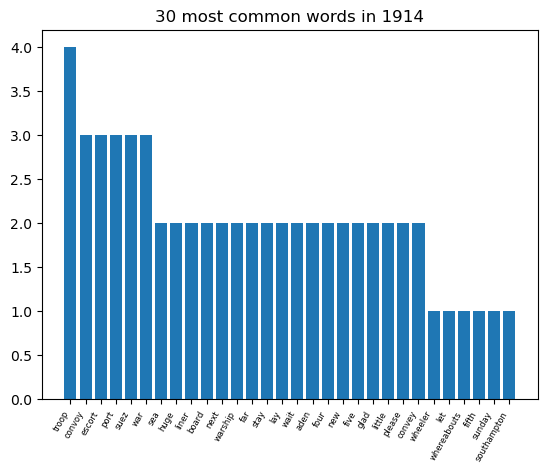

['troop', 'convoy', 'escort', 'port', 'suez', 'war', 'sea', 'huge', 'liner', 'board', 'next', 'warship', 'far', 'stay', 'lay', 'wait', 'aden', 'four', 'new', 'five', 'glad', 'little', 'please', 'convey', 'wheeler', 'let', 'whereabouts', 'fifth', 'sunday', 'southampton']

Most common bigrams of letters in 1914


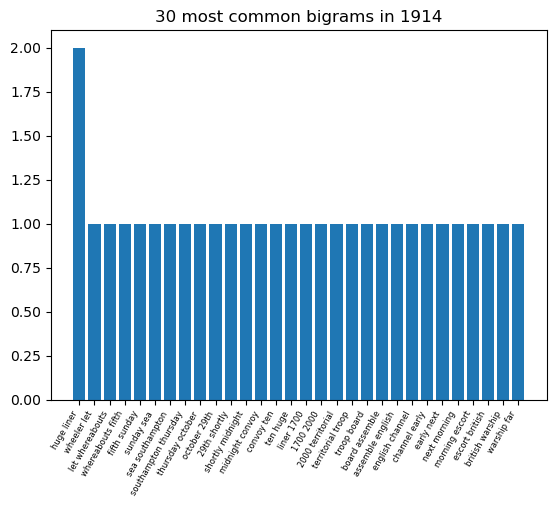

['huge liner', 'wheeler let', 'let whereabouts', 'whereabouts fifth', 'fifth sunday', 'sunday sea', 'sea southampton', 'southampton thursday', 'thursday october', 'october 29th', '29th shortly', 'shortly midnight', 'midnight convoy', 'convoy ten', 'ten huge', 'liner 1700', '1700 2000', '2000 territorial', 'territorial troop', 'troop board', 'board assemble', 'assemble english', 'english channel', 'channel early', 'early next', 'next morning', 'morning escort', 'escort british', 'british warship', 'warship far']
---
Number of letters in 1915:  30

Most common tokens of letters in 1915


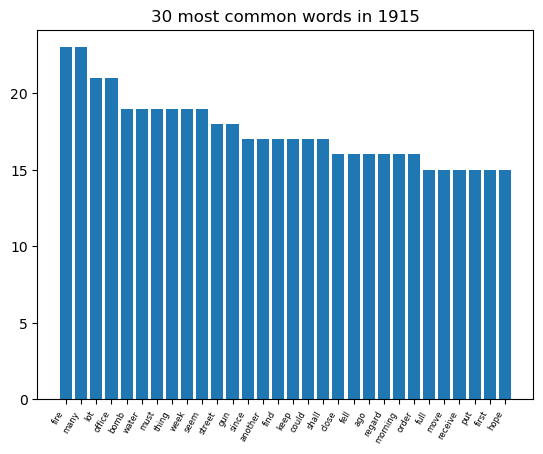

['fire', 'many', 'lot', 'office', 'bomb', 'water', 'must', 'thing', 'week', 'seem', 'street', 'gun', 'since', 'another', 'find', 'keep', 'could', 'shall', 'close', 'fell', 'ago', 'regard', 'morning', 'order', 'full', 'move', 'receive', 'put', 'first', 'hope']

Most common bigrams of letters in 1915


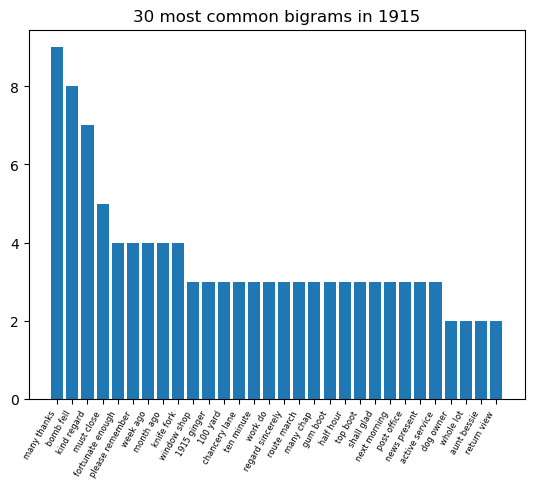

['many thanks', 'bomb fell', 'kind regard', 'must close', 'fortunate enough', 'please remember', 'week ago', 'month ago', 'knife fork', 'window shop', '1915 ginger', '100 yard', 'chancery lane', 'ten minute', 'work do', 'regard sincerely', 'route march', 'many chap', 'gum boot', 'half hour', 'top boot', 'shall glad', 'next morning', 'post office', 'news present', 'active service', 'dog owner', 'whole lot', 'aunt bessie', 'return view']
---
Number of letters in 1916:  11

Most common tokens of letters in 1916


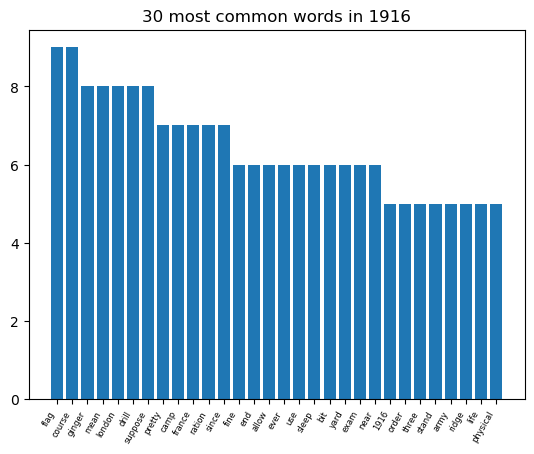

['flag', 'course', 'ginger', 'mean', 'london', 'drill', 'suppose', 'pretty', 'camp', 'france', 'ration', 'since', 'fine', 'end', 'allow', 'ever', 'use', 'sleep', 'bit', 'yard', 'exam', 'near', '1916', 'order', 'three', 'stand', 'army', 'ridge', 'life', 'physical']

Most common bigrams of letters in 1916


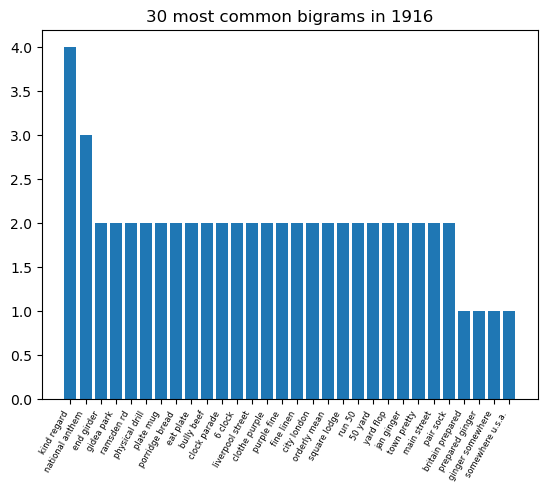

['kind regard', 'national anthem', 'end girder', 'gidea park', 'ramsden rd', 'physical drill', 'plate mug', 'porridge bread', 'eat plate', 'bully beef', 'clock parade', '6 clock', 'liverpool street', 'clothe purple', 'purple fine', 'fine linen', 'city london', 'orderly mean', 'square lodge', 'run 50', '50 yard', 'yard flop', 'jan ginger', 'town pretty', 'main street', 'pair sock', 'britain prepared', 'prepared ginger', 'ginger somewhere', 'somewhere u.s.a.']
---
Number of letters in 1917:  172

Most common tokens of letters in 1917


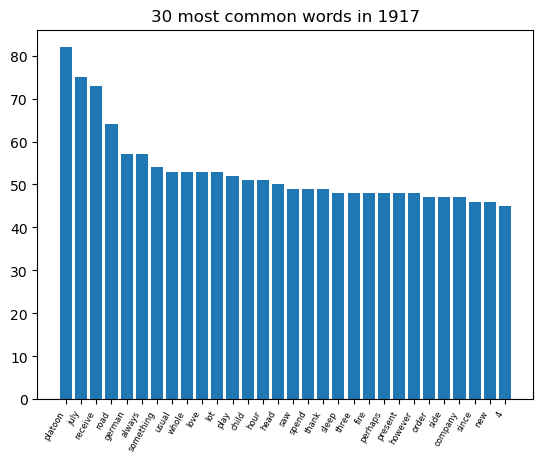

['platoon', 'july', 'receive', 'road', 'german', 'always', 'something', 'usual', 'whole', 'love', 'lot', 'play', 'child', 'hour', 'head', 'saw', 'spend', 'thank', 'sleep', 'three', 'fire', 'perhaps', 'present', 'however', 'order', 'side', 'company', 'since', 'new', '4']

Most common bigrams of letters in 1917


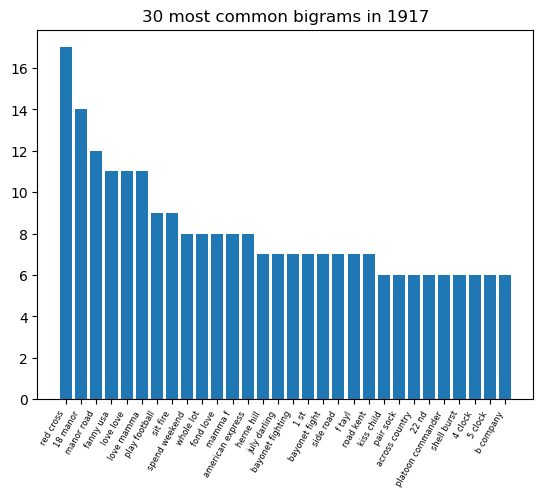

['red cross', '18 manor', 'manor road', 'fanny usa', 'love love', 'love mamma', 'play football', 'sit fire', 'spend weekend', 'whole lot', 'fond love', 'mamma f', 'american express', 'herne hill', 'july darling', 'bayonet fighting', '1 st', 'bayonet fight', 'side road', 'f tayl', 'road kent', 'kiss child', 'pair sock', 'across country', '22 nd', 'platoon commander', 'shell burst', '4 clock', '5 clock', 'b company']
---
Number of letters in 1918:  174

Most common tokens of letters in 1918


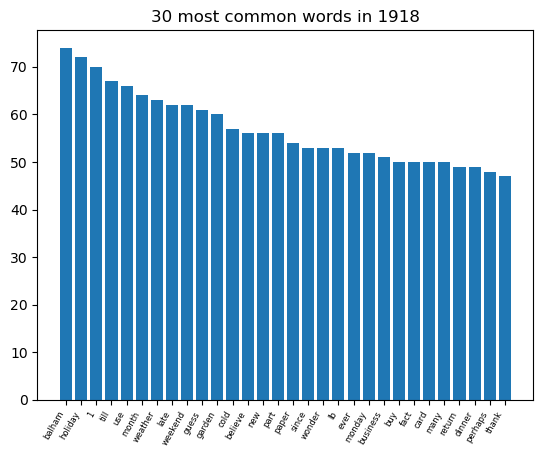

['balham', 'holiday', '1', 'till', 'use', 'month', 'weather', 'late', 'weekend', 'guess', 'garden', 'cold', 'believe', 'new', 'part', 'paper', 'since', 'wonder', 'lb', 'ever', 'monday', 'business', 'buy', 'fact', 'card', 'many', 'return', 'dinner', 'perhaps', 'thank']

Most common bigrams of letters in 1918


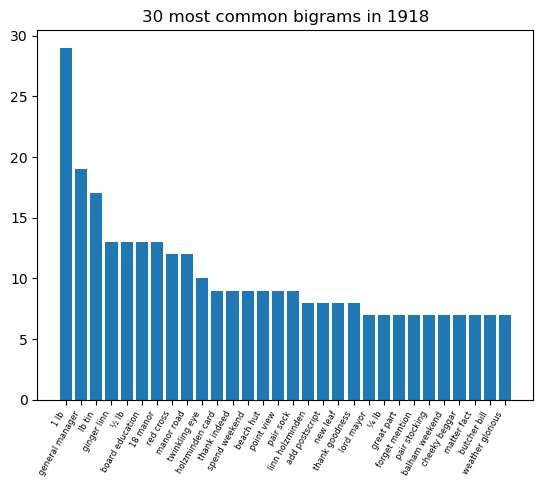

['1 lb', 'general manager', 'lb tin', 'ginger linn', '½ lb', 'board education', '18 manor', 'red cross', 'manor road', 'twinkling eye', 'holzminden card', 'thank indeed', 'spend weekend', 'beach hut', 'point view', 'pair sock', 'linn holzminden', 'add postscript', 'new leaf', 'thank goodness', 'lord mayor', '¼ lb', 'great part', 'forget mention', 'pair stocking', 'balham weekend', 'cheeky beggar', 'matter fact', 'butcher bill', 'weather glorious']
---
Number of letters in 1919:  15

Most common tokens of letters in 1919


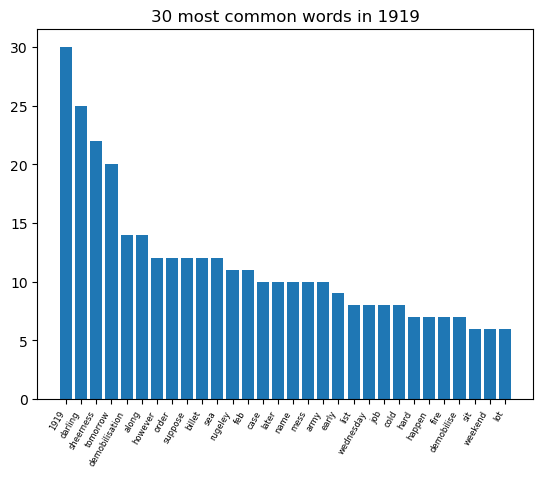

['1919', 'darling', 'sheerness', 'tomorrow', 'demobilisation', 'along', 'however', 'order', 'suppose', 'billet', 'sea', 'rugeley', 'feb', 'case', 'later', 'name', 'mess', 'army', 'early', 'list', 'wednesday', 'job', 'cold', 'hard', 'happen', 'fire', 'demobilise', 'sit', 'weekend', 'lot']

Most common bigrams of letters in 1919


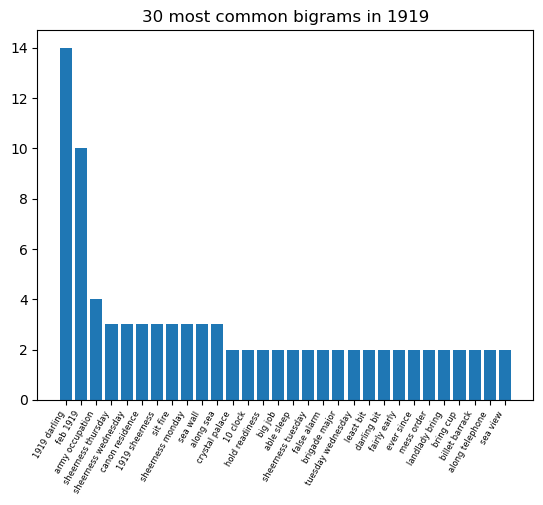

['1919 darling', 'feb 1919', 'army occupation', 'sheerness thursday', 'sheerness wednesday', 'canon residence', '1919 sheerness', 'sit fire', 'sheerness monday', 'sea wall', 'along sea', 'crystal palace', '10 clock', 'hold readiness', 'big job', 'able sleep', 'sheerness tuesday', 'false alarm', 'brigade major', 'tuesday wednesday', 'least bit', 'darling bit', 'fairly early', 'ever since', 'mess order', 'landlady bring', 'bring cup', 'billet barrack', 'along telephone', 'sea view']


In [6]:
MIN_YEAR = min(data_df["year"])
MAX_YEAR = max(data_df["year"])

letters_by_year = {
    str(year): 0
    for year in range(MIN_YEAR, MAX_YEAR + 1)
}
freqs_by_year = {
    str(year): Counter()
    for year in range(MIN_YEAR, MAX_YEAR + 1)
}
bigrams_by_year = {
    str(year): Counter()
    for year in range(MIN_YEAR, MAX_YEAR + 1)
}

for row in data_df.itertuples():
    year = str(row.year)
    tokens = row.letter.split(' ')
    letters_by_year[year] += 1
    freqs_by_year[year] += Counter(tokens)
    bigrams_by_year[year] += Counter([
        f"{pair[0]} {pair[1]}"
        for pair in bigrams(tokens)
    ])
    ''' print([
        f"{pair[0]} {pair[1]}"
        for pair in bigrams(tokens)
    ]) '''

for year in freqs_by_year.keys():
    print(f"---\nNumber of letters in {year}: ", letters_by_year[year])
    print(f"\nMost common tokens of letters in {year}")
    show_freq(freqs_by_year[year].most_common(NUM_COMMON),
              f"{NUM_COMMON} most common words in {year}",
             True)
    print(f"\nMost common bigrams of letters in {year}")
    show_freq(bigrams_by_year[year].most_common(NUM_COMMON),
              f"{NUM_COMMON} most common bigrams in {year}",
             True)

<h4>OBSERVATIONS</h4>

There is only one letter from 1914 so we don't learn too much from this.

1915 seems be to a rough start, with frequent words like "fire" and "bomb". 1916 seems to be a year of training and ceremonies, with mentions of "national anthem" and "physical drill".

1917 and 1918 both have a high number of letters (both above 100) so there's not a lot of coherence in the topics, other the mention of the Red Cross, some proper names, and household activities. The wide distribution of letter makes it harder to track a central "theme" for each of these years.

1919, being the end of the war, is characterised by many phrases suggesting as such, including "false alarm", "able sleep", and "demobilisation".